深度學習與電腦視覺馬拉松期末專題

先檢查環境


In [1]:
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2


In [2]:
import sys
print('python version:', sys.version)

python version: 3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]


In [3]:
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，


Mounted at /content/gdrive


In [4]:
# 下載基於 keras 的 yolov3 程式碼
%cd '/content/gdrive/My Drive/python_training/DL100_CV/Day_49/'
#!git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
%cd keras-yolo3

/content/gdrive/My Drive/python_training/DL100_CV/Day_49
/content/gdrive/My Drive/python_training/DL100_CV/Day_49/keras-yolo3


In [5]:
pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本

     |████████████████████████████████| 317kB 13.0MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [ ]:
# 如果之前已經解壓縮過就可以註解掉
%cd dataset/

!chmod 775 kangaroo-master.zip
!unzip kangaroo-master.zip

!chmod 775 raccoon_dataset-master.zip
!unzip raccoon_dataset-master.zip

In [6]:
%cd '/content/gdrive/My Drive/python_training/DL100_CV/Day_49/keras-yolo3/'
%ls

/content/gdrive/My Drive/python_training/DL100_CV/Day_49/keras-yolo3
coco_annotation.py      model_data/            train.py
font/                   __pycache__/           voc_annotation.py
Kangaroo-detection.avi  raccoon-detection.avi  yolo3/
kmeans.py               README.md              yolo.py
LICENSE                 train_bottleneck.py    yolo_video.py


把 YOLO weights 轉換為能夠提供給 keras 作為訓練新模型的初始權重，注意這部分多了一個 `-w` 的參數，可以參考 https://github.com/qqwweee/keras-yolo3/blob/master/convert.py#L242 以及 https://stackoverflow.com/questions/42621864/difference-between-keras-model-save-and-model-save-weights 理解其中差別

In [7]:
import os
if not os.path.exists("model_data/yolo.h5"):
  # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
  print("Model doesn't exist, downloading...")
  os.system("wget https://pjreddie.com/media/files/yolov3.weights")
  print("Converting yolov3.weights to yolo.h5...")
  os.system("python convert.py -w yolov3.cfg yolov3.weights keras-yolo3/model_data/yolo.h5") ##yolo_weights.h5
else:
  print("Model exist")

Model exist


In [8]:
# 將 train.py 所需要的套件載入
import numpy as np
import pandas as pd
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

##%cd keras-yolo3-master
from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

Using TensorFlow backend.


In [9]:
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

In [10]:
%cd "/content/gdrive/My Drive/python_training/DL100_CV/Day_49/keras-yolo3/model_data"

/content/gdrive/My Drive/python_training/DL100_CV/Day_49/keras-yolo3/model_data


In [ ]:
# 下載 tiny-yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
tiny_yolo_model_path = "yolov3-tiny.h5"  #keras-yolo3/model_data
tiny_yolo_anchor_file = "tiny_yolo_anchors.txt"
if not os.path.exists(tiny_yolo_model_path):
  print("yolov3-tiny weights doesn't exist, downloading...")
  os.system("wget https://pjreddie.com/media/files/yolov3-tiny.weights")
  print("Converting yolov3-tiny.weights to yolov3-tiny.h5...")
  os.system("python convert.py yolov3-tiny.cfg yolov3-tiny.weights %s" % tiny_yolo_model_path)
  if os.path.exists(tiny_yolo_model_path):
    print("Done!")
  else:
    print("Strange, model doesn't exist, pleace check")

In [11]:
%cd "/content/gdrive/My Drive/python_training/DL100_CV/Day_49/dataset"

/content/gdrive/My Drive/python_training/DL100_CV/Day_49/dataset


In [ ]:
# 將raccoon和kangaroo資料集轉為 yolo3可使用的格式
import numpy as np
import os

import xml.etree.ElementTree as ET 
# 載入能夠 Parser xml 文件的 library

if not os.path.exists("train.txt"):
  %cd "/content/gdrive/My Drive/python_training/DL100_CV/Day_49/dataset" 
  ##/raccoon_dataset-master  
  
  sets = ['train', 'val']
  #袋鼠class_id設為1 浣熊class_id為0
  classes = ["raccoon", "kangaroo"]
  # 將 annotation(.xml) 轉換到訓練時需要的資料形態(image_path, x_min, y_min, x_max, y_max, class_id)
  def convert_annotation(image_id, list_file):
    in_file = open('annotations/%s.xml'%(image_id))
    tree=ET.parse(in_file)
    root = tree.getroot()
    for obj in root.iter('object'):
      difficult = obj.find('difficult').text    
      cls = obj.find('name').text
      if cls not in classes or int(difficult)==1: 
        continue
      cls_id = classes.index(cls)  # class index
      #bndbox結構是存位置資訊的地方
       #寫入標記框的資訊
      xmlbox = obj.find('bndbox')
      b = (int(xmlbox.find('xmin').text), 
          int(xmlbox.find('ymin').text), 
          int(xmlbox.find('xmax').text), 
          int(xmlbox.find('ymax').text))
      list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))
    

  print("Create train.txt for training data.")
  #設定XML檔(label)和圖片檔(image)的資料夾路徑
  # 取得 raccoon 和 kangaroo images_ids
  ##Day_49/dataset/raccoon_dataset-master/images/raccoon-1.jpg
  raccoon_ids = os.listdir('raccoon_dataset-master/images')
  kangaroo_ids = os.listdir('kangaroo-master/images')
  ids = raccoon_ids + kangaroo_ids
  ids = np.char.strip(ids, '.jpeg') ##remove .jpeg

  # 將全部images的 80% 當訓練集資料
  train_ids = np.random.choice(ids, size=int(len(ids)*0.8), replace=False)
  val_ids = np.setdiff1d(ids, train_ids)
    
  # 將 ids 分別寫入 train.txt 和 val.txt
  #在當前資料夾建立一個 train.txt檔 用來存圖片的框選資訊
  t = open('train.txt', 'w')
  print('write train_ids to train.txt')
  for train_id in train_ids:
      t.write('%s' %(train_id))
      #一個XML檔的所有資料在train.txt中寫成一列 故每個XML檔讀完後要換行
      t.write('\n')
  t.close()
    
  v = open('val.txt', 'w')
  print('write val_ids to val.txt')
  for val_id in val_ids:
    v.write('%s' %(val_id))
    v.write('\n')
  v.close()
  
  # 將兩資料集的annotations 一併放入annotations資料夾
  if not os.path.exists('annotations'):
    %cd "/content/gdrive/My Drive/python_training/DL100_CV/Day_49/dataset" 
    !mkdir annotations
    !cp raccoon_dataset-master/annotations/* ./annotations
    !cp kangaroo-master/annots/* ./annotations

  # 將類別資料寫入 class.txt
  class_txt = open('class.txt', 'w')
  print("save class at class.txt")       
  for class_id in classes : 
    class_txt.write('%s' %(class_id))
    class_txt.write('\n')
  class_txt.close()

  # 寫入檔案
    #遍歷每個XML檔 統合所有資訊
  #目標 做出以下格式的train.txt檔: image_file_path box1 box2 ... boxN
  #其中box格式為: x_min,y_min,x_max,y_max,class_id 
  for image_set in sets:  # train, val
      image_ids = open('%s.txt'%(image_set)).read().strip().split()      
      annotation_path = '%s_labels.txt'%(image_set)
      list_file = open(annotation_path, 'w')
      print("save annotation at %s" % annotation_path)

      for image_id in image_ids:
        if 'raccoon' in image_id :
          list_file.write('./raccoon_dataset-master/images/%s.jpg' %(image_id))
        else :
          list_file.write('./kangaroo-master/images/%s.jpg' %(image_id))  
        convert_annotation(image_id, list_file)
        list_file.write('\n')
      list_file.close()
else:
  print("file train.txt exists")


In [12]:

epoch_num = 100
batch_size = 16
input_shape = (416,416) # multiple of 32, hw
log_dir = '/content/gdrive/My Drive/python_training/DL100_CV/Day_49/logs/0049/' 
# 訓練好的模型儲存的路徑改成0049

classes_path = '/content/gdrive/My Drive/python_training/DL100_CV/Day_49/dataset/class.txt' 
# 裡面放訓練的種類名稱 照class_id的順續放

anchors_path = '/content/gdrive/My Drive/python_training/DL100_CV/Day_49/keras-yolo3/model_data/yolo_anchors.txt'


In [13]:

# 如果超過3次的循環在loss的收歛上沒有改善就停止訓練 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=10, 
                           mode='auto',  #min
                           verbose=1)

# 每次的訓練循都去比較模型的loss是否有改善, 有就把模型的權重儲存下來  
#project49_model
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='auto', #min
                             period=10)


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES =True

# 轉換好格式的標註檔案
# 轉換好格式的 train 標註檔案 
annotation_path_train = 'train_labels.txt'
# 轉換好格式的 val 標註檔案
annotation_path_val = 'val_labels.txt'

class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='/content/gdrive/My Drive/python_training/DL100_CV/Day_49/keras-yolo3/model_data/yolov3-tiny.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='/content/gdrive/My Drive/python_training/DL100_CV/Day_49/keras-yolo3/model_data/yolo.h5') 
    # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)

with open(annotation_path_train) as f:
    lines_train = f.readlines()
with open(annotation_path_val) as f:
    lines_val = f.readlines()

np.random.seed(10101)
np.random.shuffle(lines_train)
np.random.shuffle(lines_val)
np.random.seed(None)
# 訓練資料(80%)
num_train = len(lines_train) 
# 驗證資料(20%)
num_val = len(lines_val)    

# 配置 loss funtion 和 optimizer
##optimizer = Adam(lr=0.5e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
optimizer = Adam(lr=1e-3)
# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train

model.compile(optimizer=optimizer, loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    
# 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
model.fit_generator(data_generator_wrapper(lines_train, batch_size, input_shape, anchors, num_classes),
   steps_per_epoch= max(1, num_train/batch_size),
   validation_data=data_generator_wrapper(lines_val, batch_size, input_shape, anchors, num_classes),
   validation_steps= max(1, num_val/batch_size),
   epochs=epoch_num,
   initial_epoch=0,
   callbacks=[logging, checkpoint, reduce_lr]) 
##[reduce_lr, early_stop,checkpoint][logging, checkpoint, reduce_lr]

# save the model weights
model.save_weights(log_dir + 'project49_weight_final_.h5')

# save the model
model.save(log_dir + 'project49_model_final.h5')


model.save_weights(log_dir + 'project49_weight_final_.h5')
project49_model_final.h5

test

In [14]:
%cd '/content/gdrive/My Drive/python_training/DL100_CV/Day_49/'
%ls

/content/gdrive/My Drive/python_training/DL100_CV/Day_49
dataset/                      keras-yolo3/        test/
Day41_train_yolov3_Ans.ipynb  logs/               yolov3.weights.1
Day49_project.ipynb           project49_model.h5
Kangaroo.mp4                  Raccoon.mp4


In [15]:
# 使用 YOLOv3 偵測 images 並顯示結果
from PIL import Image
%cd '/content/gdrive/My Drive/python_training/DL100_CV/Day_49/'
image = Image.open('dataset/raccoon_dataset-master/images/raccoon-37.jpg')

/content/gdrive/My Drive/python_training/DL100_CV/Day_49


/content/gdrive/My Drive/python_training/DL100_CV/Day_49/keras-yolo3












/content/gdrive/My Drive/python_training/DL100_CV/Day_49/logs/0049/project49_weight_final_.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
(416, 416, 3)
Found 1 boxes for img
raccoon 0.59 (36, 35) (415, 546)
10.246403455000063


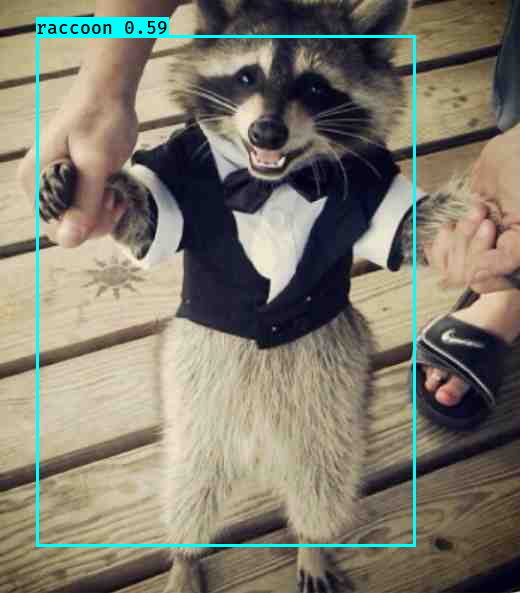

In [16]:
%cd '/content/gdrive/My Drive/python_training/DL100_CV/Day_49/keras-yolo3/'
from yolo import YOLO

#anchors_path

yolo_model = YOLO(model_path=log_dir + 'project49_weight_final_.h5', classes_path=classes_path)
r_image = yolo_model.detect_image(image)
r_image

In [17]:
!pwd

/content/gdrive/My Drive/python_training/DL100_CV/Day_49/keras-yolo3


影片辨識

In [18]:
# detect Raccoon videos
from yolo import YOLO
import numpy as np
import time
import timeit
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

%cd "/content/gdrive/My Drive/python_training/DL100_CV/Day_49/keras-yolo3/"

yolo_model = YOLO(model_path=log_dir + 'project49_weight_final_.h5', classes_path=classes_path)

starttime = timeit.default_timer()
cap = cv2.VideoCapture('/content/gdrive/My Drive/python_training/DL100_CV/Day_49/Raccoon.mp4')
#/content/gdrive/My Drive/python_training/DL100_CV/Day_49/Kangaroo.mp4
#/content/gdrive/My Drive/python_training/DL100_CV/Day_49/Raccoon.mp4
# 使用 XVID 編碼
fourcc = cv2.VideoWriter_fourcc(*'XVID')

# 建立 VideoWriter 物件，輸出影片至 output.avi
# FPS 值為 30.0，解析度為 1280*720
out = cv2.VideoWriter('raccoon-detection.avi', fourcc, 30.0, (1280, 720))

k = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        # 寫入影格
        image = Image.fromarray(frame)
        image = np.array(yolo_model.detect_image(image))
        out.write(image)
        k += 1
    else:
        break
    
# 釋放所有資源
cap.release()
out.release()

print('共耗時:',round((timeit.default_timer() - starttime), 2), '秒，FPS:', round(k/(timeit.default_timer() - starttime), 2))

串流輸出內容已截斷至最後 5000 行。
raccoon 0.31 (410, 105) (855, 601)
0.05593834799992692
(416, 416, 3)
Found 2 boxes for img
raccoon 0.30 (0, 0) (1280, 720)
raccoon 0.32 (398, 94) (863, 613)
0.05426621200001591
(416, 416, 3)
Found 2 boxes for img
raccoon 0.31 (0, 0) (1280, 720)
raccoon 0.32 (420, 104) (836, 607)
0.0578817530000606
(416, 416, 3)
Found 2 boxes for img
raccoon 0.35 (406, 101) (850, 604)
raccoon 0.35 (0, 10) (1280, 717)
0.05567962899999657
(416, 416, 3)
Found 2 boxes for img
raccoon 0.35 (0, 17) (1280, 709)
raccoon 0.36 (407, 120) (848, 582)
0.05511156199997913
(416, 416, 3)
Found 2 boxes for img
raccoon 0.32 (0, 11) (1280, 716)
raccoon 0.34 (432, 123) (827, 573)
0.05413240599989422
(416, 416, 3)
Found 2 boxes for img
raccoon 0.37 (421, 116) (840, 571)
raccoon 0.44 (0, 0) (1280, 718)
0.0582347590000154
(416, 416, 3)
Found 2 boxes for img
raccoon 0.34 (390, 115) (882, 573)
raccoon 0.38 (0, 0) (1280, 720)
0.058977407999918796
(416, 416, 3)
Found 2 boxes for img
raccoon 0.38 (378, 64) (89

In [19]:
# detect Kangaroo videos
from yolo import YOLO
import numpy as np
import time
import timeit
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

%cd "/content/gdrive/My Drive/python_training/DL100_CV/Day_49/keras-yolo3/"

yolo_model = YOLO(model_path=log_dir + 'project49_weight_final_.h5', classes_path=classes_path)

starttime = timeit.default_timer()
cap = cv2.VideoCapture('/content/gdrive/My Drive/python_training/DL100_CV/Day_49/Kangaroo.mp4')

# 使用 XVID 編碼
fourcc = cv2.VideoWriter_fourcc(*'XVID')

# 建立 VideoWriter 物件，輸出影片至 output.avi
# FPS 值為 30.0，解析度為 1280*720
out = cv2.VideoWriter('Kangaroo-detection.avi', fourcc, 30.0, (1280, 720))

k = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        # 寫入影格
        image = Image.fromarray(frame)
        image = np.array(yolo_model.detect_image(image))
        out.write(image)
        k += 1
    else:
        break
    
# 釋放所有資源
cap.release()
out.release()

print('共耗時:',round((timeit.default_timer() - starttime), 2), '秒，FPS:', round(k/(timeit.default_timer() - starttime), 2))

串流輸出內容已截斷至最後 5000 行。
Found 0 boxes for img
0.05125757999985581
(416, 416, 3)
Found 0 boxes for img
0.052012159000014435
(416, 416, 3)
Found 0 boxes for img
0.05201370000008865
(416, 416, 3)
Found 0 boxes for img
0.054026198000201475
(416, 416, 3)
Found 0 boxes for img
0.05454340100004629
(416, 416, 3)
Found 0 boxes for img
0.051626825000084864
(416, 416, 3)
Found 0 boxes for img
0.05345755899998039
(416, 416, 3)
Found 0 boxes for img
0.052261385000065275
(416, 416, 3)
Found 0 boxes for img
0.05312952100007351
(416, 416, 3)
Found 0 boxes for img
0.05146987700004502
(416, 416, 3)
Found 0 boxes for img
0.05085532099997181
(416, 416, 3)
Found 0 boxes for img
0.05333557100016151
(416, 416, 3)
Found 0 boxes for img
0.05200367800011918
(416, 416, 3)
Found 0 boxes for img
0.05156334000002971
(416, 416, 3)
Found 0 boxes for img
0.05237497999996776
(416, 416, 3)
Found 0 boxes for img
0.050846538000087094
(416, 416, 3)
Found 0 boxes for img
0.05192732600016825
(416, 416, 3)
Found 0 boxes for img
